In [1]:
pip install openimages torchmetrics tabulate

Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
import torch.nn as nn
import torchmetrics
import torchvision.transforms as transforms
from PIL import Image
import os
from openimages.download import download_dataset
from torch.utils.data import Dataset, random_split, DataLoader
from glob import glob
import numpy as np
from tabulate import tabulate

batch_size = 25
num_classes = 3
learning_rate = 0.001
num_epochs = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

c:\Users\povil\miniconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
all_transforms = transforms.Compose([transforms.Resize((227,227)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.485, 0.456, 0.406])
                                     ])

data_dir = "data"

classes = ["Person", "Food", "Animal"]

if not os.path.exists(data_dir):
  os.makedirs(data_dir)

print("Downloading is starting...")
download_dataset(data_dir, classes, limit=5000)

In [3]:
class CustomDataset(Dataset):
  def __init__(self, images_dir, transform=None):
    self.images_dir = images_dir
    self.transform = transform

    self.class1_files = glob(self.images_dir + "/{}/images/*.jpg".format(classes[0].lower()))
    self.class2_files = glob(self.images_dir + "/{}/images/*.jpg".format(classes[1].lower()))
    self.class3_files = glob(self.images_dir + "/{}/images/*.jpg".format(classes[2].lower()))

    self.class1 = len(self.class1_files)
    self.class2 = len(self.class2_files)

    self.files = self.class1_files + self.class2_files + self.class3_files

    self.labels = np.empty([len(self.files), 3])
    self.labels[:] = [1, 0, 0]
    self.labels[self.class1:] = [0, 1, 0]
    self.labels[self.class1 + self.class2:] = [0, 0, 1]

    self.order =  [x for x in np.random.permutation(len(self.labels))]
    self.files = [self.files[x] for x in self.order]
    self.labels = [self.labels[x] for x in self.order]

  def __len__(self):
    return (len(self.labels))

  def __getitem__(self, i):
    img_path = self.files[i]

    img = Image.open(img_path).convert("RGB")

    if self.transform:
      img = self.transform(img)
            
    y = self.labels[i]
    return (img, y)

In [4]:
class ConvNeuralNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [5]:
model = ConvNeuralNet(num_classes)
model.to(device)

full_dataset = CustomDataset("./data", all_transforms)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size)
test_dataloader = DataLoader(test_dataset, batch_size)

criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9) 

In [6]:
losses = []
v_losses = []

model.train(True)
for epoch in range(num_epochs):
    for _, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images).sigmoid()
        loss = criterion(outputs, labels.float())

        loss.backward()
        optimizer.step()
        
    losses.append(loss)

    with torch.no_grad():
        for _, (v_images, v_labels) in enumerate(test_dataloader):
            v_images = v_images.to(device)
            v_labels = v_labels.to(device)

            v_outputs = model(v_images).sigmoid()
            v_loss = criterion(v_outputs, v_labels.float())

        v_losses.append(v_loss)

    print('Epoch [{}/{}] - Training Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch+1, num_epochs, loss, v_loss))

model.train(False)

torch.save(model.state_dict(), "checkpoint.pth")

Epoch [1/10] - Training Loss: 0.2615, Validation Loss: 0.4053
Epoch [2/10] - Training Loss: 0.2650, Validation Loss: 0.3494
Epoch [3/10] - Training Loss: 0.2748, Validation Loss: 0.2878
Epoch [4/10] - Training Loss: 0.2468, Validation Loss: 0.2449
Epoch [5/10] - Training Loss: 0.2275, Validation Loss: 0.2593
Epoch [6/10] - Training Loss: 0.1365, Validation Loss: 0.2331
Epoch [7/10] - Training Loss: 0.1718, Validation Loss: 0.2215
Epoch [8/10] - Training Loss: 0.1729, Validation Loss: 0.2123
Epoch [9/10] - Training Loss: 0.0718, Validation Loss: 0.2085
Epoch [10/10] - Training Loss: 0.1003, Validation Loss: 0.1751


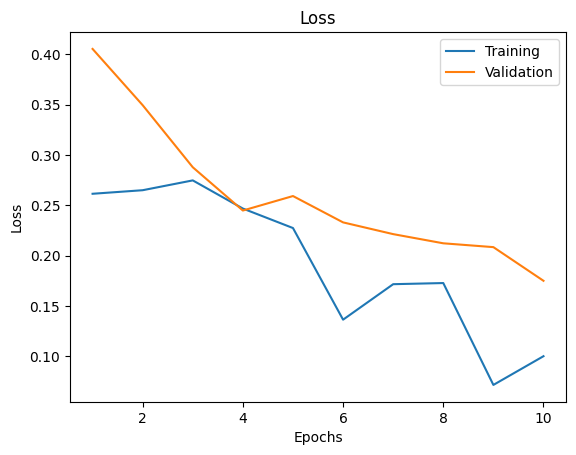

In [7]:
import matplotlib.pyplot as plt

copy_losses = [x.cpu().item() for x in losses]
copy_v_losses = [x.cpu().item() for x in v_losses]

epoch_array = list(range(1,num_epochs+1))

plt.plot(epoch_array, copy_losses, label = "Training")
plt.plot(epoch_array, copy_v_losses, label = "Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='upper right')

plt.title("Loss")

plt.show()

In [8]:
model.load_state_dict(torch.load('checkpoint.pth'))

<All keys matched successfully>

In [8]:
targets = []
predictions = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        for i, prediction in enumerate(outputs):
            predictions.append(prediction.tolist())
            targets.append(labels[i].tolist())

In [9]:
def calculateMetrics(predictions, targets):
    thresholds = (x * 0.1 for x in range(1, 10))
    metrics = []

    for t in thresholds:
        accuracy_metric = torchmetrics.classification.MultilabelAccuracy(num_labels = num_classes, threshold = t, average = "micro")
        accuracy = "{:.3f}".format(accuracy_metric(predictions, targets).item())

        precision_metric = torchmetrics.classification.MultilabelPrecision(num_labels = num_classes, threshold = t, average = "micro")
        precision = "{:.3f}".format(precision_metric(predictions, targets).item())

        recall_metric = torchmetrics.classification.MultilabelRecall(num_labels = num_classes, threshold = t, average = "micro")
        recall = "{:.3f}".format(recall_metric(predictions, targets).item())

        f1_metric = torchmetrics.classification.MultilabelF1Score(num_labels = num_classes, threshold = t, average = "micro")
        f1 = "{:.3f}".format(f1_metric(predictions, targets).item())

        metrics.append([t, accuracy, precision, recall, f1])

    return metrics

predictions_tensor = torch.tensor(predictions)
targets_tensor = torch.tensor(targets)

data = calculateMetrics(predictions_tensor, targets_tensor)
col_names = ["Threshold", "Accuracy", "Precision", "Recall", "F1"]

print(tabulate(data, headers=col_names))

  Threshold    Accuracy    Precision    Recall     F1
-----------  ----------  -----------  --------  -----
        0.1       0.691        0.52      0.936  0.668
        0.2       0.765        0.6       0.881  0.714
        0.3       0.795        0.65      0.834  0.731
        0.4       0.811        0.689     0.786  0.734
        0.5       0.822        0.726     0.747  0.736
        0.6       0.823        0.757     0.693  0.724
        0.7       0.822        0.789     0.637  0.704
        0.8       0.812        0.817     0.561  0.665
        0.9       0.791        0.873     0.438  0.583


In [9]:
def predict(image_path, model, labels):
  img = Image.open(image_path)
  img_tensor = all_transforms(img).to(device)

  output = model(img_tensor)
  pred = output.data.cpu().numpy().argmax()  # Get predicted class number
 
  print('Predicted class: {}'.format(labels[pred]))